### Program to simulate threshold of rotated surface code. 
- The error model is one stochastic Pauli error after "encoding".
- The decoding algorithm is MWPM implemented in Pymatching package. 

The program creates the lattice of qubits as a networkx graph and calculates its stabilizer generators. Errors are simulated by expressing in binary vector representation. Syndromes are calculated via the symplectic inner product. The bit flip and phase flip syndromes are decoded separately via Pymatching to get the correction. If the error followed by correction commutes with all stabilizer generators, then it is not a logical error. Otherwise, it is counted as a logical error. This is executed in a monte carlo simulation to get logical error rates.

Imports

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from pymatching import Matching
from typing import Union

Class to construct lattice of data qubits, and stabilizer generators (binary vectors) for the surface code of specified distance.

In [2]:
class rotated_surface_code():
    """
    Class to store graph representing square lattice of surface code.
    
    Calculates parity check matrix (consisting of stabilizer generators 
    in binary vector format (x|z)).
    """
    
    def __init__(self, dist: int) -> None:
        """
        Constructs the lattice of data qubits, and stabilizer generators (binary vectors)
        for the surface code of specified distance.
        
        Args:
            dist (int): Distance of the surface code to be constructed            
        """
        
        self.dist = dist
        self.rows = self.dist
        self.cols = self.dist
        self.num_qubits = self.dist**2
        
        #Initializing empty containers
        self.stab_gens = np.zeros((self.num_qubits-1, 2*self.num_qubits), dtype=np.int8)
        # To correct z errors
        self.x_stab_gens = np.zeros((int((self.num_qubits-1)/2), 2*self.num_qubits), dtype=np.int8)
        # To correct x errors
        self.z_stab_gens = np.zeros((int((self.num_qubits-1)/2), 2*self.num_qubits), dtype=np.int8)
        self.logicals = np.zeros((2, 2*self.num_qubits), dtype=np.int8)
        self.G = nx.Graph()
        
        # Calculating this stuff
        self.generate_graph()
        self.calculate_stabilizer_gens()
        self.calculate_x_and_z_stabilizer_gens()
        self.calculate_logicals()

    #############################################################################
    def generate_graph(self) -> None:
        """
        Lays out data qubits in a lattice with the following labels/coordinates:

        0(0,0)    1(0,1)    2(0,2)

        3(1,0)    4(1,1)    5(1,2)

        6(2,0)    7(2,1)    8(2,2)

        and so on for grids of larger size.

        """
        self.G = nx.Graph()
        self.positions = {}
        idx = 0
        for row in range(self.rows):
            for col in range(self.cols):
                self.G.add_node((row,col),
                                r_idx = row,
                                c_idx = col,
                                idx = idx,
                                horizontal_boundary = bool(row == 0  or row == self.rows-1),
                                vertical_boundary = bool(col == 0  or col == self.cols-1),
                                interior = bool(row != 0 and
                                                row != self.rows-1 and
                                                col != 0 and
                                                col != self.cols-1))
                self.positions[(row,col)] = (col,self.rows-row-1)
                idx += 1
    
    #############################################################################
    def draw_graph(self) -> None:
        """
        Draws the lattice of data qubits.
        """
        nx.draw_networkx(self.G, pos=self.positions)
    
    #############################################################################    
    def calculate_stabilizer_gens(self) -> None:
        """
        Calculates stabilizer generators and populates the required arrays.
        """
        stab_gen_idx = 0
        # Generate X type stabilizer generators in interior
        
        # Extract coordinates of top left qubit involved in the generator
        # Other qubits involved in the generator have coordinates which 
        # differ from top left qubit's coordinates by 1.
        for r in range(self.rows-1):
            for c in range(0,self.cols-1,2):
                stab_vec = np.zeros((1,2*self.num_qubits), dtype=np.int8)
                r_top_left = r
                if(r%2 == 0):
                    c_top_left = c
                else:
                    c_top_left = c+1
                stab_vec[0][self.G.nodes[(r_top_left,c_top_left)]["idx"]] = 1
                stab_vec[0][self.G.nodes[(r_top_left,c_top_left+1)]["idx"]] = 1
                stab_vec[0][self.G.nodes[(r_top_left+1,c_top_left)]["idx"]] = 1
                stab_vec[0][self.G.nodes[(r_top_left+1,c_top_left+1)]["idx"]] = 1
                self.stab_gens[stab_gen_idx] = stab_vec
                stab_gen_idx += 1
                
        # Generate X type stabilizer generators on upper horizontal boundary
        for c in range(0,self.cols-1,2):
            stab_vec = np.zeros((1,2*self.num_qubits), dtype=np.int8)
            r_top_left = 0
            c_top_left = c+1
            stab_vec[0][self.G.nodes[(r_top_left,c_top_left)]["idx"]] = 1
            stab_vec[0][self.G.nodes[(r_top_left,c_top_left+1)]["idx"]] = 1
            self.stab_gens[stab_gen_idx] = stab_vec
            stab_gen_idx += 1

        # Generate X type stabilizer generators on lower horizontal boundary
        for c in range(0,self.cols-1,2):
            stab_vec = np.zeros((1,2*self.num_qubits), dtype=np.int8)
            r_top_left = self.rows-1
            c_top_left = c
            stab_vec[0][self.G.nodes[(r_top_left,c_top_left)]["idx"]] = 1
            stab_vec[0][self.G.nodes[(r_top_left,c_top_left+1)]["idx"]] = 1
            self.stab_gens[stab_gen_idx] = stab_vec
            stab_gen_idx += 1
            
        # Generate Z type stabilizer generators in interior
        
        # Extract coordinates of top left qubit
        for r in range(self.rows-1):
            for c in range(0,self.cols-1,2):
                stab_vec = np.zeros((1,2*self.num_qubits), dtype=np.int8)
                r_top_left = r
                if(r%2 == 0):
                    c_top_left = c+1
                else:
                    c_top_left = c
                stab_vec[0][self.num_qubits+self.G.nodes[(r_top_left,c_top_left)]["idx"]] = 1
                stab_vec[0][self.num_qubits+self.G.nodes[(r_top_left,c_top_left+1)]["idx"]] = 1
                stab_vec[0][self.num_qubits+self.G.nodes[(r_top_left+1,c_top_left)]["idx"]] = 1
                stab_vec[0][self.num_qubits+self.G.nodes[(r_top_left+1,c_top_left+1)]["idx"]] = 1
                self.stab_gens[stab_gen_idx] = stab_vec
                stab_gen_idx += 1
                
        # Generate Z type stabilizer generators on left boundary
        for r in range(0,self.rows-1,2):
            stab_vec = np.zeros((1,2*self.num_qubits), dtype=np.int8)
            c_top_left = 0
            r_top_left = r
            stab_vec[0][self.num_qubits+self.G.nodes[(r_top_left,c_top_left)]["idx"]] = 1
            stab_vec[0][self.num_qubits+self.G.nodes[(r_top_left+1,c_top_left)]["idx"]] = 1
            self.stab_gens[stab_gen_idx] = stab_vec
            stab_gen_idx += 1

        # Generate Z type stabilizer generators on right boundary
        for r in range(0,self.rows-1,2):
            stab_vec = np.zeros((1,2*self.num_qubits), dtype=np.int8)
            r_top_left = r+1
            c_top_left = self.cols-1
            stab_vec[0][self.num_qubits+self.G.nodes[(r_top_left,c_top_left)]["idx"]] = 1
            stab_vec[0][self.num_qubits+self.G.nodes[(r_top_left+1,c_top_left)]["idx"]] = 1
            self.stab_gens[stab_gen_idx] = stab_vec
            stab_gen_idx += 1
    
    #############################################################################
    def calculate_x_and_z_stabilizer_gens(self) -> None:
        """
        Calculates X and Z type stabilizer generators in separate variables.
        """
        self.x_stab_gens = self.stab_gens[0:int((self.num_qubits-1)/2)]
        self.z_stab_gens = self.stab_gens[int((self.num_qubits-1)/2):]

    #############################################################################    
    def calculate_logicals(self) -> None:
        """
        Calculates binary vector representation of logical X and Z operators.
        """
        # Logical X
        for i in range(self.num_qubits):
            self.logicals[0,i] = 1
        
        # Logical Z
        for i in range(self.num_qubits):
            self.logicals[1,self.num_qubits+i] = 1

Example: Visualize a distance-3 aurface code and its stabilizer generators

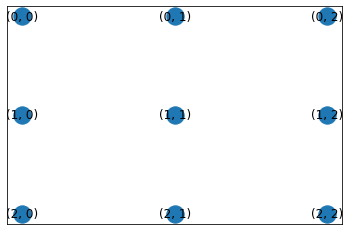

In [3]:
surf_code = rotated_surface_code(dist = 3)
surf_code.draw_graph()

In [4]:
print(surf_code.stab_gens)

[[1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1]]


Function to calculate symplectic inner product.

In [5]:
def symplectic_inner_product(v1: np.ndarray, v2: np.ndarray) -> np.ndarray:
    """
    Calculates v1 L v2^T, where L is the matrix
    0  I
    I  0
    
    Args:
        v1 (np.ndarray): a vector representing a single error vector,
            or a matrix where each row represents an error.
        v2 (np.ndarray): a vector representing a single stabilizer generator,
            or a matrix where each row represents a stabilizer generator.
            
    Returns:
        np.ndarray: Symplectic inner product of v1 and v2, 
            or matrix containing these values.
    """
    
    v1 = np.atleast_2d(v1)
    v2 = np.atleast_2d(v2)
    
    num_cols_v1 = np.shape(v1)[1]
    num_cols_v2 = np.shape(v2)[1]
    assert num_cols_v1 == num_cols_v2
    n = (int(num_cols_v1/2))
    iden = np.eye(n, dtype=np.int8)
    zero = np.zeros([n,n], dtype=np.int8)
    L = np.block([[zero,iden],[iden,zero]])

    # Don't change to 1D; 2D is useful to calculate syndromes for multiple errors at once
    return np.mod(np.matmul(v1, np.matmul(L, np.transpose(v2))), 2)

Function to simulate pseudothreshold for a code of given distance, and specified error probabilities and number of samples.

In [6]:
def simulate_pseudothreshold(dist: int, 
                             p_phys: Union[np.ndarray, list],
                             num_samples_per_p_phys: int) -> np.ndarray:
    """
    Psuedothreshold simulation of rotated surface code of specified distance (integer).
    Creates surface code object internally.
    Returns logical error probabilities for given physical error rates.
    
    Args:
        dist (int): Distance of the surface code to be constructed.
        p_phys (np.ndarray or list): Values of physical error probabilities
            for which the simulation is to be carried out.
        num_samples_per_p_phys (int): Number of samples to be collected for every
            value of physical error probability, during the monte carlo simulation.
            
    Returns:
        np.ndarray: Logical error probabilities for given physical error rates.
    """
    
    if isinstance(p_phys, list):
        p_phys = np.array(p_phys)
    
    surf_code = rotated_surface_code(dist = dist)
    
    # Matrix of errors. Every row corresponds to an error string.
    # Every column corresponds to the qubit on which the error has
    # to be injected, in binary symplectic representation (x | z).
    error = np.zeros([num_samples_per_p_phys*len(p_phys), 2*surf_code.num_qubits], dtype=np.int8)
    # Similarly, the recovery operators.
    recovery = np.zeros([num_samples_per_p_phys*len(p_phys), 2*surf_code.num_qubits], dtype=np.int8)
    
    # Generate the error strings.
    for i in range(len(p_phys)):
        for j in range(num_samples_per_p_phys):
            for n in range(surf_code.num_qubits):
                if np.random.uniform() < p_phys[i]:
                    # At this point, it has been decided that an error has to be
                    # injected on a particular data qubit. Now, decide which
                    # Pauli error is to be injected.
                    dec = np.random.uniform()
                    row_idx = (i*num_samples_per_p_phys) + j
                    if dec < (1/3):
                        # X error
                        error[row_idx][n] = 1
                    elif (dec >= (1/3)) and (dec < (2/3)):
                        # Y error
                        error[row_idx][n] = 1
                        error[row_idx][n + surf_code.num_qubits] = 1
                    elif dec >= (2/3):
                        # Z error
                        error[row_idx][n + surf_code.num_qubits] = 1
    
    # Calculate syndromes corresponding to all errors in one fell swoop via symplectic inner product.
    syndrome = symplectic_inner_product(error, surf_code.stab_gens)
    # The bits corresponding to anticommutation with Z tell you the bit flip syndrome
    x_syndrome = syndrome[:,int((surf_code.num_qubits-1)/2):]
    # The bits corresponding to anticommutation with X tell you the phase flip syndrome
    z_syndrome = syndrome[:,0:int((surf_code.num_qubits-1)/2)]

    # To correct z errors
    matching_x_gens = Matching(surf_code.x_stab_gens)
    # To correct x errors
    matching_z_gens = Matching(surf_code.z_stab_gens)
    
    # infer recovery map
    # Looping because apparently the mathcing object does not accept 
    # an array of syndromes to return corresponding corrections
    for i in range(np.shape(syndrome)[0]):
        x_prediction = matching_z_gens.decode(x_syndrome[i])
        z_prediction = matching_x_gens.decode(z_syndrome[i])
        # Overall predicted recovery operator
        recovery_prediction = np.array(np.mod(x_prediction+z_prediction, 2), dtype=np.int8)
        # Swapping, because it looks like pymatching returns the correction in the (z|x) format
        recovery_prediction = np.concatenate((recovery_prediction[surf_code.num_qubits:],
                                              recovery_prediction[0:surf_code.num_qubits]))
        recovery[i] = recovery_prediction
    
    # Calculate which errors led to a logical error
    logical_error = symplectic_inner_product(np.mod((recovery + error), 2), surf_code.logicals)
    
    # For same physical error rate, calculate the total number of logical errors
    # This does not have to be of int8 dtype! Logical error counts can exceed 128 (signed int).
    logical_error_counts = np.zeros([len(p_phys)])
    for i in range(len(p_phys)):
        for j in range(num_samples_per_p_phys):
            if((logical_error[i*num_samples_per_p_phys + j][0] == 1) or
               (logical_error[i*num_samples_per_p_phys + j][1] == 1)):
                logical_error_counts[i] += 1

    del surf_code, error, syndrome, x_syndrome, z_syndrome, matching_x_gens, matching_z_gens
    del x_prediction, z_prediction, recovery_prediction, recovery, logical_error
    return logical_error_counts

Launch a simulation for codes of different distances
- Physical error rates are 25 evenly spaced values between 0.0 and 0.20
- Collecting 10<sup>5</sup> samples for every physical error 
- Demonstrating for various distances going up to 21

In [7]:
p_phys = np.linspace(0.0,0.20,25)
num_samples_per_p_phys = 10**5
dist = {0:3,1:5,2:7,3:9,4:11,5:13,6:15,7:17,8:19,9:21}
logical_error_counts = {}

for key in dist:
    print("Simulating code of distance = ", dist[key], "...")
    logical_error_counts[key] = simulate_pseudothreshold(dist = dist[key],
                                                         p_phys = p_phys,
                                                         num_samples_per_p_phys = num_samples_per_p_phys)
print("Done.")

Simulating code of distance =  3 ...
Simulating code of distance =  5 ...
Simulating code of distance =  7 ...
Simulating code of distance =  9 ...
Simulating code of distance =  11 ...
Simulating code of distance =  13 ...
Simulating code of distance =  15 ...
Simulating code of distance =  17 ...
Simulating code of distance =  19 ...
Simulating code of distance =  21 ...
Done.


Plot the logical error rates:

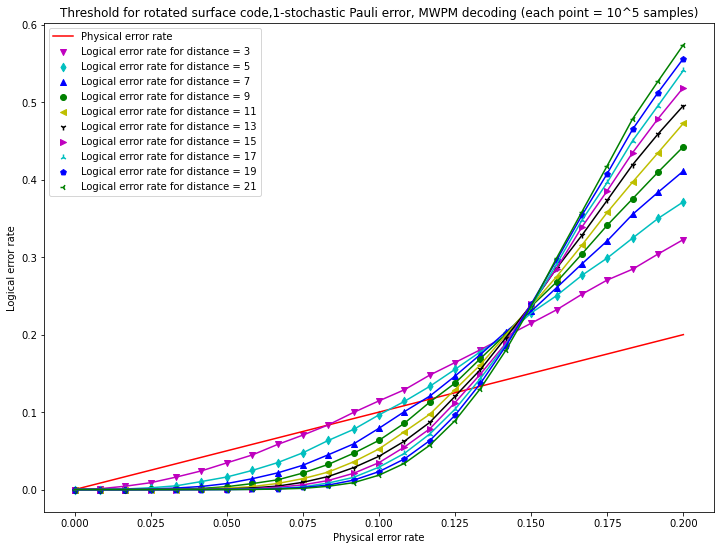

In [8]:
lc_p_phys = p_phys

fig = plt.figure(1, figsize=(12, 9))

markers = {0:'v',1:'d',2:'^',3:'o',4:'<',5:'1',6:'>',7:'2',
           8:'p',9:'3'}
colors = {0:'m',1:'c',2:'b',3:'g',4:'y',5:'k',6:'m',7:'c',
          8:'b',9:'g'}

plt.plot(lc_p_phys, lc_p_phys, 'r')
for key in dist:
    plt.scatter(lc_p_phys, logical_error_counts[key]/num_samples_per_p_phys, marker=markers[key], color=colors[key])
    plt.plot(lc_p_phys, logical_error_counts[key]/num_samples_per_p_phys, label='_nolegend_', color=colors[key])

plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')

leg = ['Physical error rate']
for key in dist:
    leg.append('Logical error rate for distance = '+str(dist[key]))
plt.legend(leg)
plt.title('Threshold for rotated surface code,'+
          '1-stochastic Pauli error, MWPM decoding '+
          '(each point = 10^'+str(int(np.log10(num_samples_per_p_phys)))+' samples)')

plt.show()

Launch a simulation for codes of different distances
- Physical error rates are 16 evenly spaced values between 0.10 and 0.17
- Collecting 10<sup>4</sup> samples for every physical error 
- Demonstrating for various distances going up to 55

In [9]:
p_phys = np.linspace(0.10,0.17,16)
num_samples_per_p_phys = 10**4
dist = {0:3,1:5,2:7,3:9,4:11,5:13,6:15,7:17,8:19,9:23,
        10:27,11:31,12:35,13:39,14:43,15:47,16:51,17:55}
logical_error_counts = {}

for key in dist:
    print("Simulating code of distance = ", dist[key], "...")
    logical_error_counts[key] = simulate_pseudothreshold(dist = dist[key],
                                                         p_phys = p_phys,
                                                         num_samples_per_p_phys = num_samples_per_p_phys)
print("Done.")

Simulating code of distance =  3 ...
Simulating code of distance =  5 ...
Simulating code of distance =  7 ...
Simulating code of distance =  9 ...
Simulating code of distance =  11 ...
Simulating code of distance =  13 ...
Simulating code of distance =  15 ...
Simulating code of distance =  17 ...
Simulating code of distance =  19 ...
Simulating code of distance =  23 ...
Simulating code of distance =  27 ...
Simulating code of distance =  31 ...
Simulating code of distance =  35 ...
Simulating code of distance =  39 ...
Simulating code of distance =  43 ...
Simulating code of distance =  47 ...
Simulating code of distance =  51 ...
Simulating code of distance =  55 ...
Done.


Plot the logical error rates:

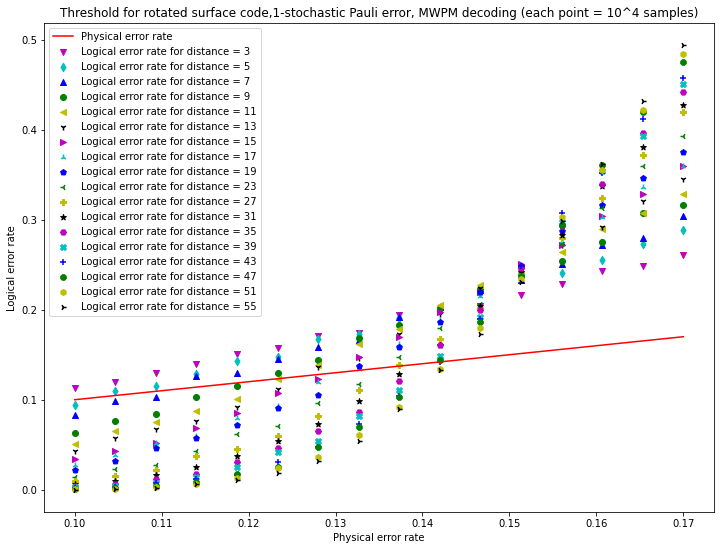

In [10]:
lc_p_phys = p_phys

fig = plt.figure(1, figsize=(12, 9))

markers = {0:'v',1:'d',2:'^',3:'o',4:'<',5:'1',6:'>',7:'2',
           8:'p',9:'3',10:'P',11:'*',12:'H',13:'X',14:'+',
           15:'8',16:'h',17:'4'}
colors = {0:'m',1:'c',2:'b',3:'g',4:'y',5:'k',6:'m',7:'c',
          8:'b',9:'g',10:'y',11:'k',12:'m',13:'c',14:'b',
          15:'g',16:'y',17:'k'}

plt.plot(lc_p_phys, lc_p_phys, 'r')
for key in dist:
    plt.scatter(lc_p_phys, logical_error_counts[key]/num_samples_per_p_phys, marker=markers[key], color=colors[key])

plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')

leg = ['Physical error rate']
for key in dist:
    leg.append('Logical error rate for distance = '+str(dist[key]))
plt.legend(leg)
plt.title('Threshold for rotated surface code,'+
          '1-stochastic Pauli error, MWPM decoding '+
          '(each point = 10^'+str(int(np.log10(num_samples_per_p_phys)))+' samples)')

plt.show()

References:
- https://qecsim.github.io/overview.html#introduction
- Deep neural decoders for near term fault-tolerant experiments. Christopher Chamberland and Pooya Ronagh 2018 Quantum Sci. Technol. 3 044002.